# **`SKU110K` - Dataset Consolidation**

***
***

In [3]:
%pip install pandas numpy seaborn matplotlib opencv-python Pillow tqdm

  Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached pillow-11.2.1-cp313-cp313-win_amd64.whl.metadata (9.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp313-cp313-win_amd64.whl.metadata (104 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached pandas-2.2.3-cp313-cp313-win_amd64.whl (11.5 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.1-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached pillow-11.2.1-cp313-cp313-win_amd64.whl (2.7

In [1]:
# Import necessary libraries
import os
import shutil
import json
import glob
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Define paths
input_base_path = "./SKU110K_Kaggle"
output_base_path = "./SKU110K_consolidated"
output_images_path = os.path.join(output_base_path, "images")
output_annotations_path = os.path.join(output_base_path, "annotations")

# Create output directories if they don't exist
os.makedirs(output_base_path, exist_ok=True)
os.makedirs(output_images_path, exist_ok=True)
os.makedirs(output_annotations_path, exist_ok=True)

In [3]:
# Function to verify dataset structure
def verify_dataset_structure(base_path):
    """Verify the SKU110K dataset has the expected directory structure."""
    expected_dirs = [
        os.path.join(base_path, "images", "train"),
        os.path.join(base_path, "images", "val"),
        os.path.join(base_path, "images", "test"),
        os.path.join(base_path, "labels", "train"),
        os.path.join(base_path, "labels", "val"),
        os.path.join(base_path, "labels", "test")
    ]
    
    all_exist = True
    for dir_path in expected_dirs:
        if not os.path.exists(dir_path):
            print(f"Missing directory: {dir_path}")
            all_exist = False
    
    return all_exist

In [4]:
# Verify dataset structure
print("Verifying dataset structure...")
if not verify_dataset_structure(input_base_path):
    raise ValueError("Dataset structure is not as expected. Please check the input path.")
else:
    print("Dataset structure verified ✓")

Verifying dataset structure...
Dataset structure verified ✓


In [5]:
# Count files in dataset
def count_files(base_path):
    """Count image and annotation files in each split."""
    splits = ["train", "val", "test"]
    counts = {}
    
    for split in splits:
        img_path = os.path.join(base_path, "images", split)
        lbl_path = os.path.join(base_path, "labels", split)
        
        img_count = len(glob.glob(os.path.join(img_path, "*.jpg")) + 
                         glob.glob(os.path.join(img_path, "*.jpeg")) + 
                         glob.glob(os.path.join(img_path, "*.png")))
        
        lbl_count = len(glob.glob(os.path.join(lbl_path, "*.txt")))
        
        counts[split] = {"images": img_count, "labels": lbl_count}
    
    return counts

# Count files in dataset
file_counts = count_files(input_base_path)
print("\nFile counts in original dataset:")
for split, count in file_counts.items():
    print(f"  {split}: {count['images']} images, {count['labels']} annotation files")


File counts in original dataset:
  train: 8185 images, 8185 annotation files
  val: 584 images, 584 annotation files
  test: 2920 images, 2920 annotation files



Visualizing examples from original dataset...


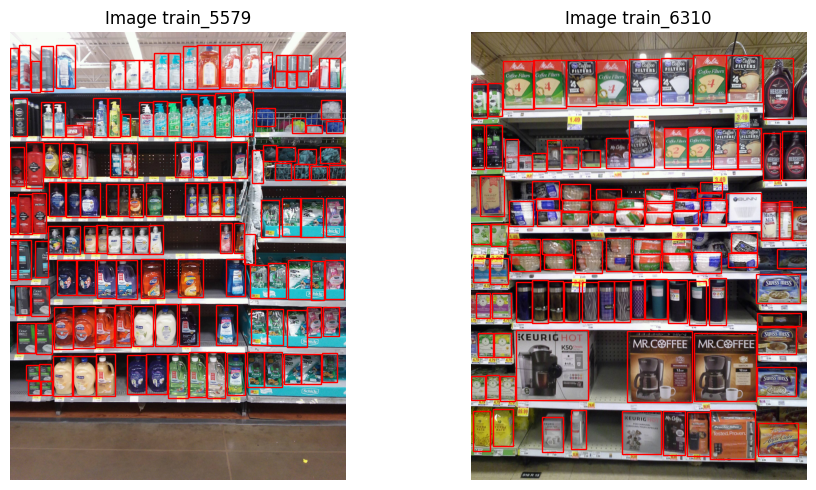

In [6]:
# Visualization function to verify annotations
def visualize_annotations(image_path, annotation_path, n_samples=3):
    """Visualize random images with their bounding boxes."""
    # Get all image files
    image_files = sorted(glob.glob(os.path.join(image_path, "*.jpg")))
    
    if len(image_files) == 0:
        print("No images found to visualize.")
        return
    
    # Select random samples
    np.random.seed(42)  # For reproducibility
    indices = np.random.choice(len(image_files), min(n_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(1, len(indices), figsize=(5*len(indices), 5))
    if len(indices) == 1:
        axes = [axes]
    
    for i, idx in enumerate(indices):
        img_file = image_files[idx]
        img_id = os.path.basename(img_file).split('.')[0]
        ann_file = os.path.join(annotation_path, f"{img_id}.txt")
        
        # Load image
        img = Image.open(img_file)
        img_width, img_height = img.size
        
        # Display image
        axes[i].imshow(img)
        axes[i].set_title(f"Image {img_id}")
        
        # Load annotations
        if os.path.exists(ann_file):
            with open(ann_file, 'r') as f:
                annotations = f.readlines()
            
            # Draw bounding boxes
            for ann in annotations:
                parts = ann.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, width, height = map(float, parts)
                    
                    # Convert to pixel coordinates for display
                    x_min = (x_center - width/2) * img_width
                    y_min = (y_center - height/2) * img_height
                    rect_width = width * img_width
                    rect_height = height * img_height
                    
                    # Create rectangle patch
                    rect = plt.Rectangle((x_min, y_min), rect_width, rect_height,
                                         linewidth=1, edgecolor='r', facecolor='none')
                    axes[i].add_patch(rect)
        
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize a few examples from the original dataset
print("\nVisualizing examples from original dataset...")
split_sample = "train"  # Change to view different splits
visualize_annotations(
    os.path.join(input_base_path, "images", split_sample),
    os.path.join(input_base_path, "labels", split_sample),
    n_samples=2
)

In [7]:
# Get all images and their corresponding annotation files
splits = ["train", "val", "test"]

# Initialize counters and collections
image_counter = 0
annotations_jsonl = []

In [8]:
# Process each split
print("\nConsolidating dataset...")
for split in splits:
    images_path = os.path.join(input_base_path, "images", split)
    labels_path = os.path.join(input_base_path, "labels", split)
    
    # Get all image files in this split
    image_files = sorted(glob.glob(os.path.join(images_path, "*.jpg")) + 
                        glob.glob(os.path.join(images_path, "*.jpeg")) + 
                        glob.glob(os.path.join(images_path, "*.png")))
    
    print(f"Processing {len(image_files)} images from {split} split...")
    split_start_idx = image_counter  # Track starting index for this split
    
    # Process each image file
    for image_file in tqdm(image_files):
        # Get corresponding annotation file
        base_name = os.path.basename(image_file).split('.')[0]
        annotation_file = os.path.join(labels_path, f"{base_name}.txt")
        
        # Check if annotation file exists
        if not os.path.exists(annotation_file):
            print(f"Warning: No annotation found for {image_file}, skipping.")
            continue
        
        # Copy image to new location with numerical name
        new_image_name = f"{image_counter}.jpg"
        new_image_path = os.path.join(output_images_path, new_image_name)
        shutil.copy2(image_file, new_image_path)
        
        # Read image to get dimensions
        img = Image.open(image_file)
        img_width, img_height = img.size
        
        # Read annotation file
        with open(annotation_file, 'r') as f:
            bbox_annotations = f.readlines()
        
        # Process each bounding box for JSONL
        bounding_boxes = []
        for bbox_line in bbox_annotations:
            parts = bbox_line.strip().split()
            if len(parts) != 5:
                print(f"Warning: Invalid annotation format in {annotation_file}, line: {bbox_line}")
                continue
                
            class_id, x_center, y_center, width, height = map(float, parts)
            
            # Convert from center coordinates to min-max coordinates (still normalized)
            x_min = float(x_center) - float(width)/2
            y_min = float(y_center) - float(height)/2
            x_max = float(x_center) + float(width)/2
            y_max = float(y_center) + float(height)/2
            
            # Ensure coordinates are within [0, 1] range
            x_min = max(0, min(1, x_min))
            y_min = max(0, min(1, y_min))
            x_max = max(0, min(1, x_max))
            y_max = max(0, min(1, y_max))
            
            bounding_boxes.append({
                "displayName": "product",  # Using 'product' as the class label
                "xMin": x_min,
                "yMin": y_min,
                "xMax": x_max,
                "yMax": y_max
            })
        
        # Create JSONL entry for Vertex AI Datasets
        jsonl_entry = {
            "imageGcsUri": f"gs://sku-110k-dataset/SKU110K_consolidated/images/{new_image_name}",  # Placeholder
            "boundingBoxAnnotations": bounding_boxes,
        }
        
        annotations_jsonl.append(jsonl_entry)
        
        # Also save the original annotation format with new name for reference
        with open(os.path.join(output_annotations_path, f"{image_counter}.txt"), 'w') as f:
            f.write(''.join(bbox_annotations))
        
        # Increment counter
        image_counter += 1


Consolidating dataset...
Processing 8185 images from train split...


100%|██████████| 8185/8185 [00:28<00:00, 290.52it/s]


Processing 584 images from val split...


100%|██████████| 584/584 [00:02<00:00, 267.46it/s]


Processing 2920 images from test split...


100%|██████████| 2920/2920 [00:10<00:00, 272.01it/s]


In [9]:
# Save annotations to JSONL file
jsonl_path = os.path.join(output_base_path, "annotations.jsonl")
with open(jsonl_path, 'w') as f:
    for entry in annotations_jsonl:
        f.write(json.dumps(entry) + '\n')

print(f"\nDataset consolidation complete:")
print(f"- {image_counter} total images processed")
print(f"- Images saved to: {output_images_path}")
print(f"- Annotations saved to: {output_annotations_path}")
print(f"- JSONL file saved to: {jsonl_path}")


Dataset consolidation complete:
- 11689 total images processed
- Images saved to: ./SKU110K_consolidated\images
- Annotations saved to: ./SKU110K_consolidated\annotations
- JSONL file saved to: ./SKU110K_consolidated\annotations.jsonl



Visualizing examples from consolidated dataset:


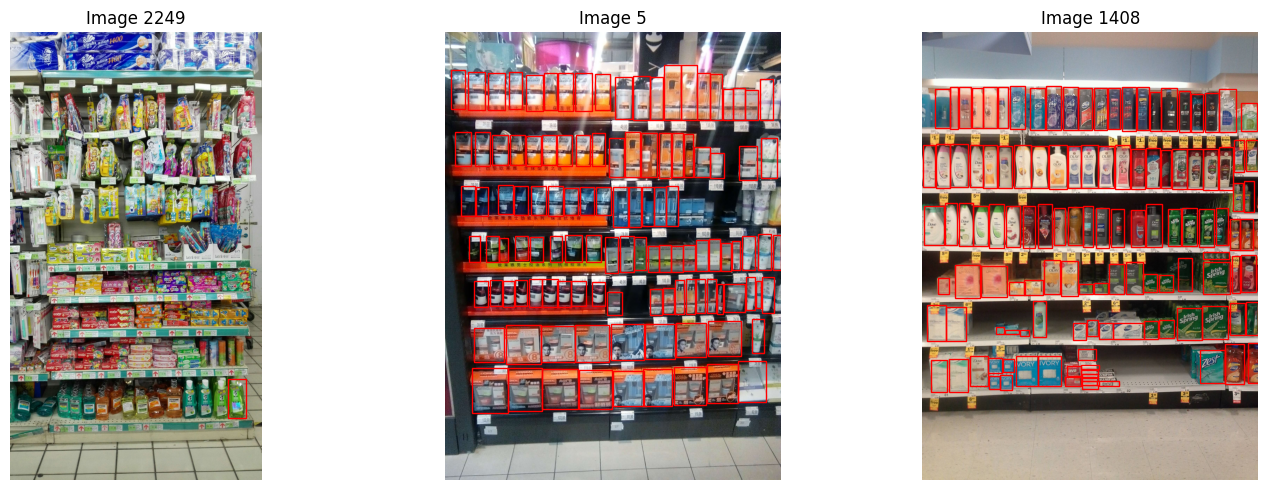

In [10]:
# Visualize examples from the consolidated dataset
print("\nVisualizing examples from consolidated dataset:")
visualize_annotations(output_images_path, output_annotations_path, n_samples=3)

In [11]:
# Print a sample JSONL entry (first 3 bounding boxes only for brevity)
if annotations_jsonl:
    sample_entry = annotations_jsonl[0].copy()
    if len(sample_entry['boundingBoxAnnotations']) > 3:
        sample_entry['boundingBoxAnnotations'] = sample_entry['boundingBoxAnnotations'][:3]
        sample_entry['boundingBoxAnnotations'].append({"...": "..."})
    print("\nSample JSONL entry (truncated):")
    print(json.dumps(sample_entry, indent=2))


Sample JSONL entry (truncated):
{
  "imageGcsUri": "gs://sku-110k-dataset/SKU110K_consolidated/images/0.jpg",
  "boundingBoxAnnotations": [
    {
      "displayName": "product",
      "xMin": 0.06878306878306878,
      "yMin": 0.17757936507936506,
      "xMax": 0.13955026455026456,
      "yMax": 0.2691798941798942
    },
    {
      "displayName": "product",
      "xMin": 0.41931216931216936,
      "yMin": 0.6359126984126985,
      "xMax": 0.4513888888888889,
      "yMax": 0.730489417989418
    },
    {
      "displayName": "product",
      "xMin": 0.37533068783068785,
      "yMin": 0.6858465608465608,
      "xMax": 0.4169973544973545,
      "yMax": 0.7162698412698413
    },
    {
      "...": "..."
    }
  ]
}


***
***

In [ ]:
3. Perform Data Analysis in the same notebook.
4. Pre-process the dataset and generate TFRecords shards in a separate notebook locally for the consolidated dataset.
5. Upload the consolidated dataset as SKU110K_consolidated with the .jsonl annotations, and processed TFRecords shards as SKU110K_TFRecords dataset in the GCS bucket all by using the GCloud CLI on the local system.


Let us begin with the first notebook.